In [1]:
import math
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(12,6))

In [2]:
X, y = make_classification(n_samples=1000, n_features=10, random_state=0)
np.unique(y, return_counts=True)

(array([0, 1]), array([499, 501]))

## Vanilla Python

In [3]:
def py_accuracy(y_pred, y):
    size = len(y)
    result = 0
    for i in range(size):
        result += round(y_pred[i]) == y[i]
    return result / size
    
def py_dot_product(vec1, vec2):
    size = len(vec1)
    result = [0] * size
    for i in range(size):
        result[i] = vec1[i] * vec2[i]
    return sum(result)
    
    
def py_sigmoid(x):
    return 1 / (1 + math.e**-x)

def py_forward(w, X):
    size = len(X)
    predict = [0] * size
    for i in range(size):
        dot = py_dot_product(X[i], w)
        predict[i] = py_sigmoid(dot)
    return predict

def py_loss(predict, y):
    size = len(y)
    result = 0
    for i in range(size):
        p_1 = - y[i] * math.log(predict[i])
        p_0 = -(1 - y[i]) * math.log(1 - predict[i])
        result += p_0 + p_1
    return result / size

# Jacobian is the same
def py_grad(predict, X, y):
    size = len(y)
    column_size = len(X[0])
    grad = [0] * column_size
    for i in range(size):
        vals = [0] * column_size
        for j in range(column_size):
            grad[j] += (predict[i] - y[i]) * X[i][j]
    return grad

def py_update_params(w, grad, lr):
    return [w[i] - lr * grad[i] for i in range(len(w))]

In [4]:
py_X = np.insert(X, 0, 1, axis=1).tolist()
py_y = y.tolist()
py_w = [0]*len(py_X[0])

In [5]:
n_iter = 10
history = [0] * n_iter
accuracy = [0] * n_iter
for i in range(n_iter):
    pred = py_forward(py_w, py_X)
    history[i] = py_loss(pred, py_y)
    accuracy[i] = py_accuracy(pred, py_y)
    grad = py_grad(pred, py_X, py_y)
    py_w = py_update_params(py_w, grad, 0.001)

print("Accuracy:", accuracy[-1])

Accuracy: 0.945


In [6]:
np.array(py_w)

array([ 0.10926956, -0.0345767 , -0.00194332,  0.6339341 ,  1.04793049,
       -0.03072205,  0.08916048,  1.45113449, -0.01019018, -0.00855314,
       -0.03996327])

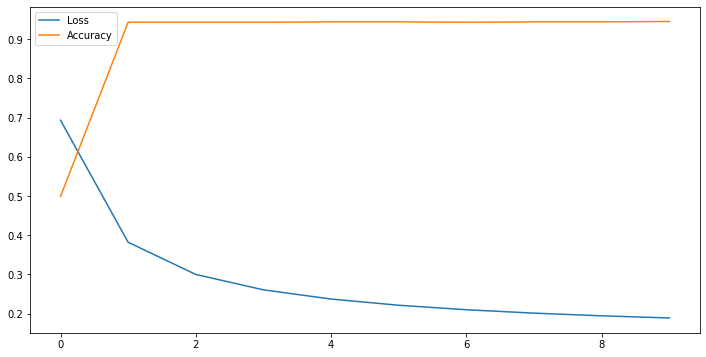

In [7]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## Numpy

In [8]:
def np_accuracy(y_pred, y):
    return np.mean(np.round(y_pred) == y)
        
def np_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_forward(w, X):
    return np_sigmoid(X.dot(w))

def np_loss(y_pred, y):
    p_1 = -y * np.log(y_pred)
    p_0 = -(1 - y) * np.log(1 - y_pred)
    return np.mean(p_0 + p_1)

# Same Jacobian
def np_grad(y_pred, X, y):
    column_size = X.shape[1]
    grad = np.empty(column_size)
    for i in range(column_size):
        grad[i] = np.sum((y_pred - y) * X[:, i])
    return grad

# Pass by reference
def np_update_params(w, grad, lr):
    w -= lr * grad

In [9]:
np_X = np.insert(X, 0, 1, axis=1)
np_y = y
np_w = np.zeros(np_X.shape[1])

In [10]:
n_iter = 10
history = np.empty(n_iter)
accuracy = [0] * n_iter
for i in range(n_iter):
    pred = np_forward(np_w, np_X)
    history[i] = np_loss(pred, np_y)
    accuracy[i] = np_accuracy(pred, py_y)
    grad = np_grad(pred, np_X, np_y)
    np_update_params(np_w, grad, 0.001)

print("Accuracy:", accuracy[-1])

Accuracy: 0.945


In [11]:
np_w

array([ 0.10926956, -0.0345767 , -0.00194332,  0.6339341 ,  1.04793049,
       -0.03072205,  0.08916048,  1.45113449, -0.01019018, -0.00855314,
       -0.03996327])

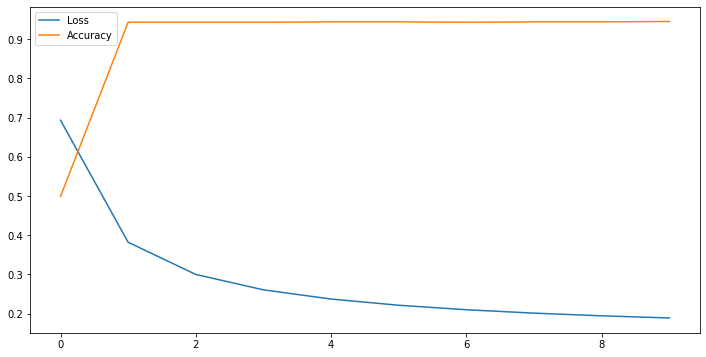

In [12]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## Jax

In [13]:
import jax
from jax import jit
from jax import grad as jgrad
from jax import numpy as jnp

# Setting device to cpu
jax.config.update('jax_platform_name', 'cpu')

In [14]:
@jit
def jax_accuracy(y_pred, y):
    return jnp.mean(jnp.round(y_pred) == y)

@jit
def jax_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

@jit
def jax_forward(w, X):
    return jax_sigmoid(X.dot(w))

@jit
def jax_loss(w, X, y):
    y_pred = jax_forward(w, X)
    p_1 = -y * jnp.log(y_pred) 
    p_0 = -(1 - y) * jnp.log(1 - y_pred) 
    return jnp.mean(p_0 + p_1)

jax_grad = jit(jgrad(jax_loss))

@jit
def jax_update_params(w, grad, lr):
    # Jax does not allow side effects
    # So have to return a new array
    return w - grad * lr

In [15]:
# Jax have not implemented insertion yet
# and I do not think it will because of
# its functional and immutable arrays

jax_X = jnp.array(np.insert(X, 0, 1, axis=1))
jax_y = jnp.array(y)
jax_w = jnp.zeros(jax_X.shape[1])

In [16]:
n_iter = 10
history = jnp.empty(n_iter)
accuracy = jnp.empty(n_iter)
lr = jnp.array(1.)
for i in range(n_iter):
    pred = jax_forward(jax_w, jax_X)
    loss = jax_loss(jax_w, jax_X, jax_y)
    acc = jax_accuracy(pred, jax_y)
    history = jax.ops.index_update(history, i, loss)
    accuracy = jax.ops.index_update(accuracy, i, acc)
    grad = jax_grad(jax_w, jax_X, jax_y)

    # For me gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    jax_w = jax_update_params(jax_w, grad, lr)
    
print("Accuracy:", acc)

Accuracy: 0.94500005


In [17]:
jax_w

DeviceArray([ 0.10926955, -0.03457669, -0.00194332,  0.6339342 ,
              1.0479305 , -0.03072206,  0.08916049,  1.4511346 ,
             -0.0101902 , -0.00855312, -0.03996328], dtype=float32)

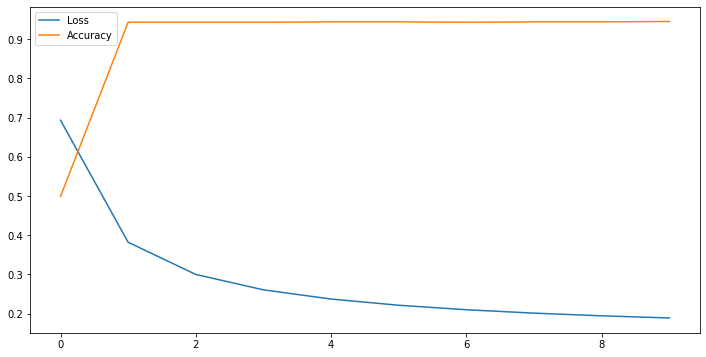

In [18]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## MxNet

In [19]:
import mxnet as mx

In [20]:
def mx_accuracy(y_pred, y):
    return mx.nd.mean(mx.nd.round(y_pred) == y)

def mx_sigmoid(x):
    return 1 / (1 + mx.nd.exp(-x))

def mx_forward(w, X):
    return mx_sigmoid(mx.nd.dot(X, w))

def mx_loss(y_pred, y):
    p_1 = -y * mx.nd.log(y_pred)
    p_0 = -(1 - y) * mx.nd.log(1 - y_pred)
    return mx.nd.mean(p_0 + p_1)

def mx_update_params(w, grad, lr):
    return w - lr * grad

In [21]:
# Mx already uses numpy inserting
# so I used numpy 
mx_X = mx.nd.array(np.insert(X, 0, 1, axis=1))
mx_y = mx.nd.array(y)
mx_w = mx.nd.zeros((mx_X.shape[1]))

In [22]:
n_iter = 10
history = mx.nd.empty(n_iter)
accuracy = mx.nd.empty(n_iter)
for i in range(n_iter):
    mx_w.attach_grad()
    with mx.autograd.record():
        pred = mx_forward(mx_w, mx_X)
        loss = mx_loss(pred, mx_y)
    history[i] = loss.asscalar()
    accuracy[i] = mx_accuracy(pred, mx_y).asscalar()
    loss.backward()
    
    # Same as jax gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    mx_w = mx_update_params(mx_w, mx_w.grad, 1)
    
print("Accuracy:", accuracy[-1].asscalar())

Accuracy: 0.945


In [23]:
mx_w.asnumpy()

array([ 0.10926956, -0.0345767 , -0.00194332,  0.63393414,  1.0479305 ,
       -0.03072206,  0.08916049,  1.4511344 , -0.01019019, -0.00855316,
       -0.03996328], dtype=float32)

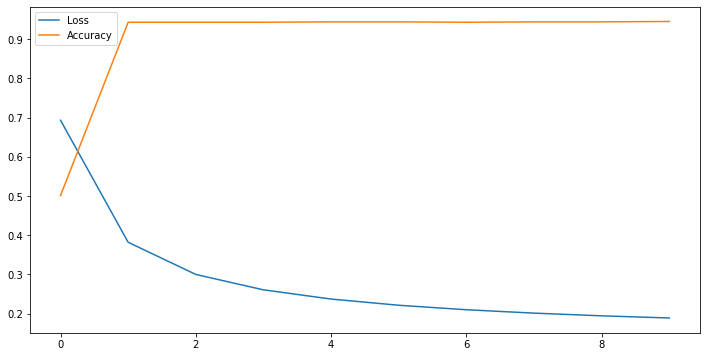

In [24]:
plt.plot(history.asnumpy())
plt.plot(accuracy.asnumpy())
plt.legend(["Loss", "Accuracy"])
plt.show()

## Tensorflow

In [25]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [26]:
tf.cast

<function tensorflow.python.ops.math_ops.cast(x, dtype, name=None)>

In [27]:
def tf_accuracy(y_pred, y):
    return tf.math.reduce_mean(tf.cast(tf.round(y_pred) == y, dtype=tf.float64))

def tf_sigmoid(x):
    return 1 / (1 + tf.exp(-x))

def tf_forward(w, X):
    return tf_sigmoid(tf.tensordot(X, w, 1))

def tf_loss(y_pred, y):
    p_1 = -y * tf.math.log(y_pred)
    p_0 = -(1 - y) * tf.math.log(1 - y_pred)
    return tf.math.reduce_mean(p_0 + p_1)

def tf_update_params(w, grad, lr):
    # Do not do operations without builtin assing op functions
    # Or it will break variable and tf cannot calculate gradients
    w.assign_sub(lr * grad)

In [28]:
# Insertion can be done with scatter
# but due to immutability of tensor
# I prefer to use numpy again
tf_X = tf.constant(np.insert(X, 0, 1, axis=1))
tf_y = tf.constant(y, dtype=tf.double)
tf_w = tf.Variable(tf.zeros((tf_X.shape[1]), dtype=tf.double))

In [29]:
n_iter = 10
# What I hate about tensorflow is that it is a real close box
# You cannot assign a value by all correctness
# There is always you a caveat, so I had to use numpy for history
history = np.empty(n_iter)
accuracy = np.empty(n_iter)
for i in range(n_iter):
    with tf.GradientTape() as tape:
        pred = tf_forward(tf_w, tf_X)
        loss = tf_loss(pred, tf_y)
    history[i] = loss.numpy()
    accuracy[i] = tf_accuracy(pred, tf_y).numpy()
    grad = tape.gradient(loss, tf_w)

    # Same as jax gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    tf_update_params(tf_w, grad, 1.0)
print("Accuracy:", accuracy[-1])

Accuracy: 0.945


In [30]:
tf_w

<tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([ 0.10926956, -0.0345767 , -0.00194332,  0.6339341 ,  1.04793049,
       -0.03072205,  0.08916048,  1.45113449, -0.01019018, -0.00855314,
       -0.03996327])>

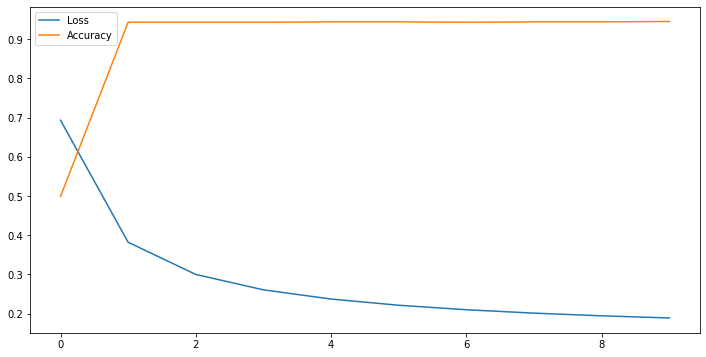

In [31]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()

## Torch

In [32]:
import torch

In [33]:
def torch_accuracy(y_pred, y):
    return torch.mean((torch.round(y_pred) == y).float())

def torch_sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def torch_forward(w, X):
    return torch_sigmoid(X @ w)

def torch_loss(y_pred, y):
    p_1 = -y * torch.log(y_pred)
    p_0 = -(1 - y) * torch.log(1 - y_pred)
    return torch.mean(p_0 + p_1)

In [34]:
torch_X = torch.from_numpy(X)
torch_X = torch.cat((torch.ones((torch_X.shape[0], 1)), torch_X), 1)
torch_y = torch.from_numpy(y)
torch_w = torch.zeros(torch_X.shape[1], dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.SGD([torch_w], lr=1)

In [35]:
n_iter = 10
history = torch.empty(n_iter)
accuracy = torch.empty(n_iter)
for i in range(n_iter):
    pred = torch_forward(torch_w, torch_X)
    loss = torch_loss(pred, torch_y)
    history[i] = loss.item()
    accuracy[i] = torch_accuracy(pred, torch_y).item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [36]:
torch_w

tensor([ 0.1093, -0.0346, -0.0019,  0.6339,  1.0479, -0.0307,  0.0892,  1.4511,
        -0.0102, -0.0086, -0.0400], dtype=torch.float64, requires_grad=True)

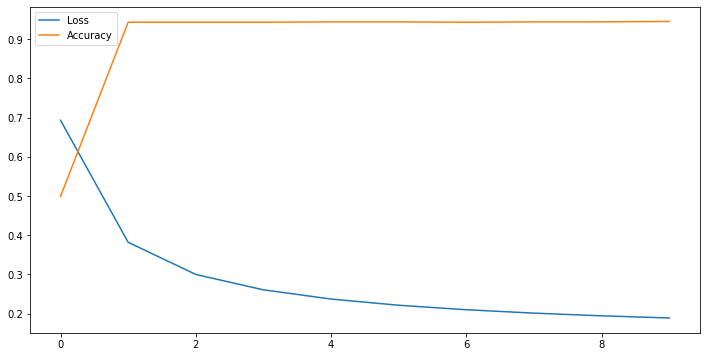

In [37]:
plt.plot(history)
plt.plot(accuracy)
plt.legend(["Loss", "Accuracy"])
plt.show()